<a href="https://colab.research.google.com/github/Yoshiki0418/-Generation-AI/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



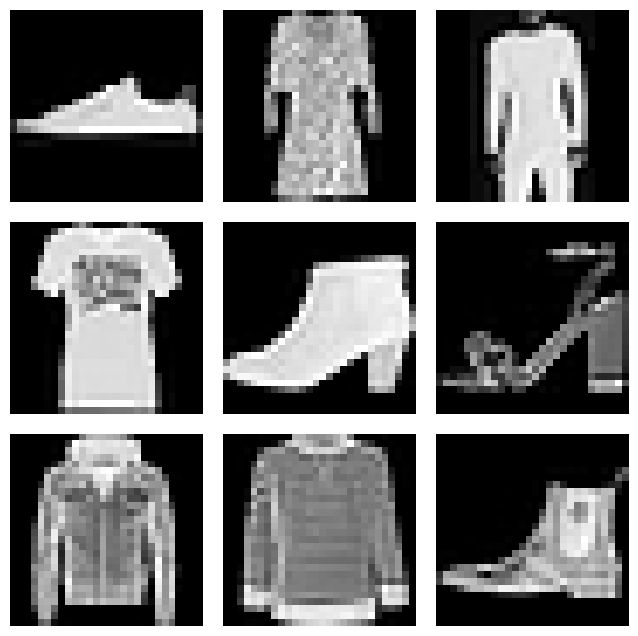

In [ ]:
# プロットの設定
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# サブプロットを作成して画像を表示
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

# サブプロット間のスペースを調整
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # wspace: 横の間隔, hspace: 縦の間隔

plt.show()

In [ ]:
# 画像データの形状を確認
print(f"画像の形状：{training_data[1][0].shape}")
print(f"画像の枚数：{len(training_data)}")

画像の形状：torch.Size([1, 28, 28])
画像の枚数：60000


### ハイパーパラメータの設定

画像の幅と高さが28x28であるので、入力層は784層のニューロンが必要である。
また、オートエンコーダは入力と出力が同じになるように学習していくので、出力層のニューロン数は、入力層と一緒にする。<br>
今回は入力層と中間層(1層)、出力層の３層でニューラルネットワークを構築する。

In [ ]:
image_size = 28
m_dim = 128

a = 0.01
epochs = 100
batch_size = 16

### モデルの設定

In [ ]:
from torch import nn
import torch
import torch.nn.functional as F

class AutoEncoder(nn.Module):
  def __init__(self, image_size: tuple[int] | int):
    super().__init__()
    self.in_dim = self._iamge_checker(image_size)
    self.encoder = nn.Linear(self.in_dim, m_dim)
    self.decoder = nn.Linear(m_dim, self.in_dim)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x.view(-1, self.in_dim)
    x = F.relu(self.encoder(x))
    x = F.relu(self.decoder(x))
    return x

  def _iamge_checker(self, image_size):
    if isinstance(image_size, tuple):
      return image_size[0] * image_size[1]
    else:
      return image_size * image_size

autoencoder = AutoEncoder(image_size)
autoencoder.cuda()  # GPU対応
print(autoencoder)

AutoEncoder(
  (encoder): Linear(in_features=784, out_features=128, bias=True)
  (decoder): Linear(in_features=128, out_features=784, bias=True)
)


In [ ]:
from torch import optim

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

# 二乗和誤差
loss_fnc = nn.MSELoss()

# Adam
optimizer = optim.Adam(autoencoder.parameters())

# 損失のログ
record_loss_train = []

# 学習
for i in range(epochs):
    autoencoder.train()  # 訓練モード
    loss_train = 0
    for j, x in enumerate(train_loader):  # ミニバッチ（x,）を取り出す
        x = x[0].cuda()  # GPU対応
        y_pred = autoencoder(x)
        x = x.view(-1, 784)
        loss = loss_fnc(y_pred, x)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%10 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)

Epoch: 0 Loss_Train: 0.02063312775741021
Epoch: 10 Loss_Train: 0.018905476731806994
Epoch: 20 Loss_Train: 0.018852029974013567
Epoch: 30 Loss_Train: 0.018401788002749286
Epoch: 40 Loss_Train: 0.018399637057632208
Epoch: 50 Loss_Train: 0.018345753374199074
Epoch: 60 Loss_Train: 0.018330868956198294
Epoch: 70 Loss_Train: 0.0181878425223132
Epoch: 80 Loss_Train: 0.01819092751418551
Epoch: 90 Loss_Train: 0.01818116054361065


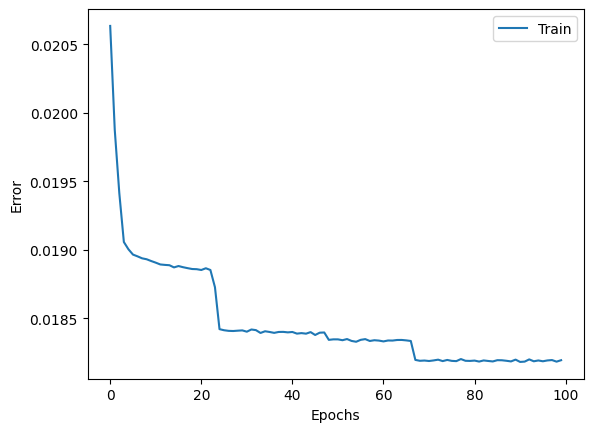

In [ ]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### 生成された画像の表示

画像が適切に再構築されているかを確認する。

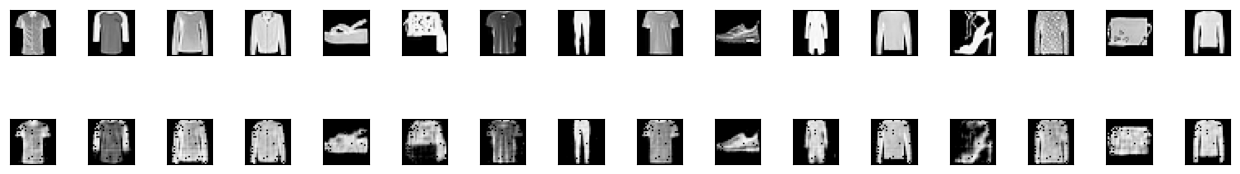

In [ ]:
x = next(iter(train_loader))[0]
x = x.cuda()

autoencoder.eval()
y_pred = autoencoder(x)

# cuda->cpu, torch->numpy
x_sample = x.cpu().detach().numpy()
y_sample = y_pred.cpu().detach().numpy()

plt.figure(figsize=(batch_size, 2))
for i in range(batch_size):
  # 入力画像
  ax = plt.subplot(3, batch_size, i+1)
  plt.imshow(x_sample[i].reshape(image_size, -1), cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # 出力画像
  ax = plt.subplot(3, batch_size, i+1+2*batch_size)
  plt.imshow(y_sample[i].reshape(image_size, -1).tolist(), cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()